# Nabewerking Klimaatsommen

In [18]:
import os
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from osgeo import gdal
import sys
import importlib.resources as pkg_resources  # Load resource from package
import ipywidgets as widgets
import json
with open(os.getcwd() + "/notebook_data.json") as f:
    notebook_data = json.load(f)
    
from hhnk_threedi_tools import Folders
import hhnk_threedi_tools as htt
import hhnk_research_tools as hrt

# import hhnk_threedi_tools.core.climate_scenarios as hrt_climate
import hhnk_threedi_tools.core.climate_scenarios.maskerkaart as maskerkaart
import hhnk_threedi_tools.core.climate_scenarios.ruimtekaart as ruimtekaart
from hhnk_threedi_tools.core.climate_scenarios.interpolate_rasters import (
    main_interpolate_rasters,
)
import hhnk_threedi_tools.core.climate_scenarios.schadekaart as schadekaart
import hhnk_threedi_tools.core.climate_scenarios.peilgebieden as peilgebieden
from hhnk_threedi_tools.core.climate_scenarios.schadekaart_peilgebieden import maak_schade_polygon
from hhnk_threedi_tools.core.climate_scenarios.masker_filter_rasters import (
    rasterize_maskerkaart,
    apply_mask_to_raster,
    remove_mask_from_raster,
)
from numpy.lib.function_base import kaiser


## Folder inladen

In [19]:
folder = Folders(notebook_data['polder_folder'])

v6


## Selecteer neerslagzone en dem

Selecteer map met batch resultaten


Select(layout=Layout(grid_area='output_folder_box', width='95%'), options=('bwn_test #5 (1) klimaatsommen', 'h…

Selecteer neerslagzone


Select(layout=Layout(grid_area='precipitation_zone_box', width='95%'), options=('hevig', 'debilt'), rows=2, va…

Selecteer DEM bestand


Dropdown(layout=Layout(grid_area='dem_path_dropdown', width='95%'), options=('dem_hoekje.tif', 'dem_thoekje_vo…

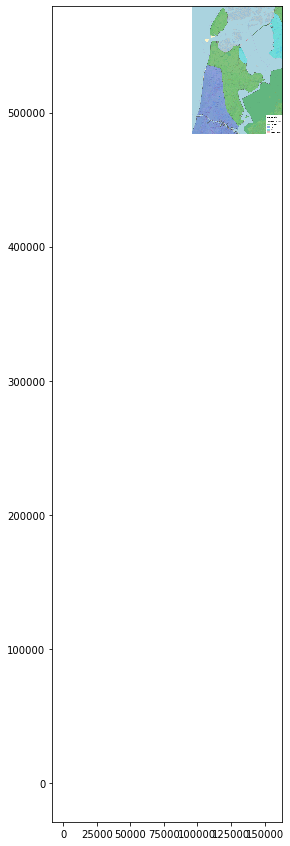

In [20]:
def item_layout(width="95%", grid_area="", **kwargs):
    return widgets.Layout(
        width=width, grid_area=grid_area, **kwargs
    )  # override the default width of the button to 'auto' to let the button grow


output_folder_options = folder.threedi_results.batch.content

# output_folder_label = widgets.Label('Selecteer output folder:', layout=item_layout(grid_area='output_folder_label'))
output_folder_box = widgets.Select(
    options=output_folder_options,
    rows=3,
    disabled=False,
    layout=item_layout(grid_area="output_folder_box"),
)


# Set Dem path if its not found
dem_path_dropdown = widgets.Dropdown(
    options="",
    disabled=False,
    layout=item_layout(grid_area="dem_path_dropdown"),
)


if folder.model.rasters.find_dem() == "":
    dem_path_dropdown.options = [
        i.split(os.sep)[-1] for i in folder.model.rasters.find_ext("tif")
    ]
else:
    dem_path_dropdown.options = [folder.model.rasters.dem.name + ".tif"]
# Batch folder selection


# Display precipitation zones
polder_shape = gpd.read_file(folder.source_data.polder_polygon.path)
with pkg_resources.path(htt.resources, "precipitation_zones_hhnk.tif") as p:
    neerslag_list, neerslag_nodata, neerslag_meta = hrt.load_gdal_raster(
        p.absolute().as_posix(), band_count=3
    )
with pkg_resources.path(htt.resources, "precipitation_frequency.xlsx") as p:
    freqs = pd.read_excel(p.absolute().as_posix())

fig, ax = plt.subplots(figsize=(15, 15))
ax.imshow(neerslag_list, extent=neerslag_meta['bounds'])
polder_shape.plot(ax=ax, color='red')


precipitation_zone_box = widgets.Select(
    options=["hevig", "debilt"],
    rows=2,
    disabled=False,
    value=None,
    layout=item_layout(grid_area="precipitation_zone_box"),
)

print("Selecteer map met batch resultaten")
display(output_folder_box)
print("Selecteer neerslagzone")
display(precipitation_zone_box)
print("Selecteer DEM bestand")
display(dem_path_dropdown)

## Lokaliseren polder folder

In [21]:
batch_fd = folder.threedi_results.batch[output_folder_box.value]

df = pd.DataFrame(batch_fd.downloads.names, columns=["dl_name"])
for dl_name in batch_fd.downloads.names:
    df.loc[df["dl_name"] == dl_name, "max_depth"] = getattr(
        batch_fd.downloads, dl_name
    ).max_depth.path
    df.loc[df["dl_name"] == dl_name, "total_damage"] = getattr(
        batch_fd.downloads, dl_name
    ).total_damage.path


## %%

freqs = freqs[["dl_name", "freq_{}_jaar".format(precipitation_zone_box.value)]]
freqs.rename(
    {"freq_{}_jaar".format(precipitation_zone_box.value): "freq_jaar"},
    axis=1,
    inplace=True,
)

df_freqs = df.merge(freqs, on="dl_name")

## %% Aanmaken of laden peilgebieden polygon
if not folder.source_data.peilgebieden.peilgebieden.exists:
    fixeddrainage = folder.source_data.datachecker.load("fixeddrainagelevelarea")
    fixeddrainage.to_file(folder.source_data.peilgebieden.peilgebieden.path)
    print(
        f"Peilgebieden shapefile aangemaakt: {folder.source_data.peilgebieden.peilgebieden.name}.shp"
    )
else:
    print(
        f"Peilgebieden shapefile gevonden: {folder.source_data.peilgebieden.peilgebieden.name}.shp"
    )

Peilgebieden shapefile gevonden: peilgebieden.shp


## Maskerkaart aanmaken

In [22]:
# Aanmaken polygon van maskerkaart
maskerkaart.command(
    path_piek=batch_fd.downloads.piek_GHG_T1000.netcdf.path,
    path_blok=batch_fd.downloads.blok_GHG_T1000.netcdf.path,
    path_out=batch_fd.output.maskerkaart.path,
)

# Omzetten polygon in raster voor diepteraster
_, _, depth_meta = hrt.load_gdal_raster(
    batch_fd.downloads.piek_GLG_T10.max_depth.path, return_array=False
)
mask_depth = rasterize_maskerkaart(
    input_file=batch_fd.output.maskerkaart.path,
    mask_plas_path=batch_fd.output.mask_diepte_plas.path,
    mask_overlast_path=batch_fd.output.mask_diepte_overlast.path,
    meta=depth_meta,
)

# Omzetten polygon in raster voor schaderaster (kan verschillen van diepte met andere resolutie)
_, _, damage_meta = hrt.load_gdal_raster(
    batch_fd.downloads.piek_GLG_T10.total_damage.path, return_array=False
)
mask_damage = rasterize_maskerkaart(
    input_file=batch_fd.output.maskerkaart.path,
    mask_plas_path=batch_fd.output.mask_schade_plas.path,
    mask_overlast_path=batch_fd.output.mask_schade_overlast.path,
    meta=damage_meta,
)

C:\Users\chris.kerklaan\Documents\Github\hhnk-threedi-tools\test_polder\03_3di_resultaten\batch_results\hoekje_volledig\02_output_rasters\maskerkaart.shp already exists
C:\Users\chris.kerklaan\Documents\Github\hhnk-threedi-tools\test_polder\03_3di_resultaten\batch_results\hoekje_volledig\02_output_rasters\mask_diepte_plas.tif already exists
C:\Users\chris.kerklaan\Documents\Github\hhnk-threedi-tools\test_polder\03_3di_resultaten\batch_results\hoekje_volledig\02_output_rasters\mask_diepte_overlast.tif already exists
C:\Users\chris.kerklaan\Documents\Github\hhnk-threedi-tools\test_polder\03_3di_resultaten\batch_results\hoekje_volledig\02_output_rasters\mask_schade_plas.tif already exists
C:\Users\chris.kerklaan\Documents\Github\hhnk-threedi-tools\test_polder\03_3di_resultaten\batch_results\hoekje_volledig\02_output_rasters\mask_schade_overlast.tif already exists


## Peilgebieden rasterizeren

In [23]:
for raster_type, raster_name in zip(
    ["max_depth", "total_damage"], ["diepte", "schade"]
):
    peilgebieden.rasterize_peilgebieden(
        input_raster=hrt.Raster(df.iloc[0][raster_type]),
        output_file=getattr(batch_fd.output.temp, f"peilgebieden_{raster_name}"),
        input_peilgebieden=folder.source_data.peilgebieden.peilgebieden,
        output_peilgebieden=batch_fd.output.temp.peilgebieden,
        mask_path=batch_fd.output.maskerkaart.path,
        overwrite=False,
    )

peilgebieden_diepte already exists
peilgebieden_schade already exists


## Maskerkaart aanmaken

In [24]:
if not batch_fd.output.ruimtekaart.exists:
    # if True:
    ruimtekaart.create_ruimtekaart(
        pgb_path=batch_fd.output.temp.peilgebieden.path,
        output_path=batch_fd.output.ruimtekaart.path,
        batch_fd=batch_fd,
    )
    print("Ruimtekaart created")

## Interpoleren van schaderasters

In [25]:
diepte_rasters = df_freqs["max_depth"].values
frequenties = df_freqs["freq_jaar"].values


for T in [10, 100, 1000]:

    output_file = getattr(batch_fd.output, f"depth_T{T}_totaal")

    # Voor de gegeven herhalingstijd, interpoleer de rasters.
    main_interpolate_rasters(
        T=T,
        output_file=output_file,
        rasters=diepte_rasters,
        frequenties=frequenties,
        output_nodata=-9999.00,
        dem_path=folder.model.rasters.full_path(dem_path_dropdown.value),
        extra_nodata_value=0,
    )

C:\Users\chris.kerklaan\Documents\Github\hhnk-threedi-tools\test_polder\03_3di_resultaten\batch_results\hoekje_volledig\02_output_rasters\inundatiediepte_T0010.tif already exists
C:\Users\chris.kerklaan\Documents\Github\hhnk-threedi-tools\test_polder\03_3di_resultaten\batch_results\hoekje_volledig\02_output_rasters\inundatiediepte_T0100.tif already exists
C:\Users\chris.kerklaan\Documents\Github\hhnk-threedi-tools\test_polder\03_3di_resultaten\batch_results\hoekje_volledig\02_output_rasters\inundatiediepte_T1000.tif already exists


## Plas en overlast kaarten maken

In [26]:
for T in [10, 100, 1000]:
    input_raster = hrt.Raster(getattr(batch_fd.output, f"depth_T{T}_totaal").path)

    # Creeer masker voor plas en overlast
    for mask_type in ["plas", "overlast"]:
        mask = hrt.Raster(getattr(batch_fd.output, f"mask_diepte_{mask_type}").path)

        output_raster = getattr(batch_fd.output, f"depth_T{T}_{mask_type}")

        if not output_raster.exists:
            raster_array = input_raster._read_array()
            mask_array = mask._read_array()

            raster_array[~(mask_array == 1)] = input_raster.nodata  # Maskeer
            hrt.save_raster_array_to_tiff(
                output_file=output_raster.path,
                raster_array=raster_array,
                nodata=input_raster.nodata,
                metadata=input_raster.metadata,
            )
            print(f"{output_raster.name} created")

        else:
            print(f"{output_raster.name} already exists")
raster_array = None
mask_array = None

inundatiediepte_T0010_plas already exists
inundatiediepte_T0010_overlast already exists
inundatiediepte_T0100_plas already exists
inundatiediepte_T0100_overlast already exists
inundatiediepte_T1000_plas already exists
inundatiediepte_T1000_overlast already exists


## Schadekaart maken

In [27]:
dv = 0.04  # discontovoet [%]
n = 50  # investeringstermijn [jaren]
schade_rasters = df_freqs["total_damage"].values
frequencies = df_freqs["freq_jaar"].values
output_raster = batch_fd.output.cw_schade_totaal

if not output_raster.exists:
    schadekaart.main_maak_schadekaart(
        output_raster=output_raster,
        schade_rasters=schade_rasters,
        frequencies=frequencies,
        output_nodata=0,
        dv=dv,
        n=n,
    )

    print(f"{output_raster.name} created")
else:
    print(f"{output_raster.name} already exists")

cw_schade already exists


## Maak masker voor plas en overlast

In [28]:
input_raster = hrt.Raster(batch_fd.output.cw_schade_totaal.path)

# Creeer masker voor plas en overlast
for mask_type in ["plas", "overlast"]:
    mask = hrt.Raster(getattr(batch_fd.output, f"mask_schade_{mask_type}").path)

    output_raster = getattr(batch_fd.output, f"cw_schade_{mask_type}")

    if not output_raster.exists:
        raster_array = input_raster._read_array()
        mask_array = mask._read_array()

        raster_array[~(mask_array == 1)] = input_raster.nodata
        hrt.save_raster_array_to_tiff(
            output_file=output_raster.path,
            raster_array=raster_array,
            nodata=input_raster.nodata,
            metadata=input_raster.metadata,
        )
        print(f"{output_raster.name} created")

    else:
        print(f"{output_raster.name} already exists")
raster_array = None
mask_array = None

cw_schade_plas already exists
cw_schade_overlast already exists


## Bereken totale schade

In [29]:
schade_gdf = gpd.read_file(batch_fd.output.temp.peilgebieden.path)
labels_raster = hrt.Raster(batch_fd.output.temp.peilgebieden_schade.path)
labels_index = schade_gdf["index"].values

output_file = batch_fd.output.schade_peilgebied.path


# Bereken totale schade per peilgebied voor de twee gemaskerde schaderasters.
for mask_type, mask_name in zip(["plas", "overlast"], ["mv", "ws"]):
    schade_raster = hrt.Raster(getattr(batch_fd.output, f"cw_schade_{mask_type}").path)

    # Calculate sum per region
    accum = schade_raster.sum_labels(
        labels_raster=labels_raster, labels_index=labels_index
    )

    schade_gdf[f"cw_{mask_name}"] = accum

schade_gdf["cw_tot"] = schade_gdf["cw_ws"] + schade_gdf["cw_mv"]

# schade_gdf = schade_gdf.loc[schade_gdf['cw_tot'] > 0.0]


schade_per_polder = (
    schade_gdf[["name", "cw_tot", "cw_ws", "cw_mv"]]
    .groupby("name")
    .sum()
    .sort_values(by="cw_ws", ascending=False)
)

# Opslaan naar shapefile en csv
schade_gdf.to_file(output_file)
schade_per_polder.to_csv(batch_fd.output.schade_polder.path)

# Schade corrigeren
Als er schade op treedt op plekken waar dit niet logisch is, kan je een shapefile aanmaken die we vervolgens uit het raster zullen knippen. Maak hiervoor het volgende bestand aan:
.\01. DAMO HDB en Datachecker\peilgebieden\geen_schade.shp

In [30]:
raster = hrt.Raster(str(batch_fd.output.cw_schade_plas))

dv = 0.04 #discontovoet [%]
n = 50 #investeringstermijn [jaren]
cw_factor = (1 - (1 - dv) ** n) / dv
pixel_factor = raster.metadata['pixel_width']**2/0.25 #niet nodig als resolutie goed staat


## Verwijder onrealistische schades


In [31]:
maskerkaart2 = gpd.read_file(str(folder.source_data.peilgebieden.geen_schade)) #load maskerkaart (geen_schade.shp)

maskerkaart_union = maskerkaart2.buffer(0.1).unary_union.buffer(-0.1) #make one geometry from gdf.
    
#Rasterize polygon
maskerkaart_union = gpd.GeoDataFrame(geometry=[maskerkaart_union])
#Voeg kolom toe aan gdf, deze waarden worden in het raster gezet.
maskerkaart_union['val']=1

mask = hrt.gdf_to_raster(maskerkaart_union, value_field='val', raster_out='', nodata=0, metadata=damage_meta, epsg=28992, driver='MEM')
mask = mask > 0

In [32]:
for mask_type, mask_name in zip(["plas", "overlast"], ["mv", "ws"]):
    schade_raster = hrt.Raster(getattr(batch_fd.output, f"cw_schade_{mask_type}").path)
    output = str(batch_fd.output) +  f"/cw_schade_{mask_type}_correctie.tif"
    array = schade_raster.get_array()
    array[mask] = raster.nodata
    hrt.save_raster_array_to_tiff(output, array, raster.nodata, raster.metadata)

In [33]:
schade_raster_corr_file={"plas": str(batch_fd.output.cw_schade_plas_corr),
                        "overlast": str(batch_fd.output.cw_schade_overlast_corr)}
schades, schade_per_polder = maak_schade_polygon(peilgebiedenbestand=str(folder.source_data.peilgebieden.peilgebieden), 
                                                 schade_raster_file=schade_raster_corr_file, 
                                                 pixel_factor=pixel_factor, 
                                                 output_schade_file=str(batch_fd.output.schade_peilgebied_corr), 
                                                 output_polder_file=str(batch_fd.output.schade_polder_corr))



[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [ ]:
dir(htt.core.climate_scenarios)

In [ ]:
import importlib
importlib.reload(maak_schade_polygon)